# Overview
In this Notebook I explore the infamous Kaggle Titanic data set and then use a series of classifcation models to predict survivorship with a hold out test set.

In [1366]:
# Import libraries
import csv
import os
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import seaborn as sns  # pretty plotting, including heat map
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
%matplotlib inline

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [1367]:
# Set working directory and read in data
os.getcwd()
os.chdir("/Users/rachelmartonik/MSDS_422/Python/titanic")
train_df = pd.read_csv('train.csv') # Import Titanic training data set
train_df.head() # View first 5 rows of data set

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis


In [1368]:
# Check for missing data
train_df.info() # Missing data for Age, Cabin, and Embarked


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [1369]:
train_df = train_df.drop(['Name', 'Ticket', 'Cabin'], axis=1) # Dropping these variables for now
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


In [1370]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1371]:
train_df.isnull().sum() # check for missing data - Age and Embarked

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

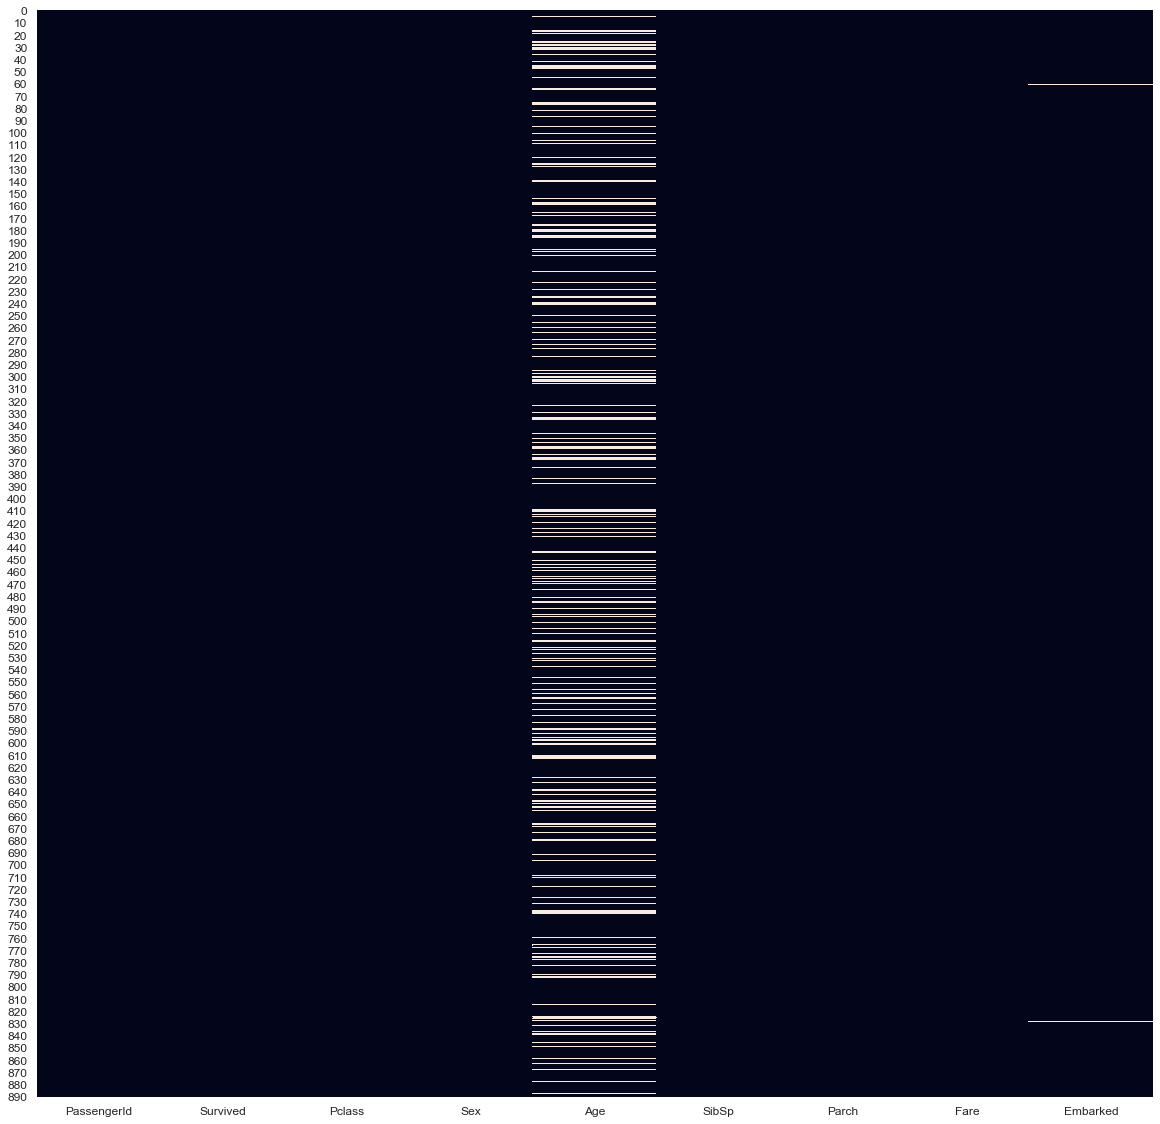

In [1372]:
# Heatmap of missing data
plt.figure(figsize=(20, 20))
sns.heatmap(train_df.isnull(), cbar = False)

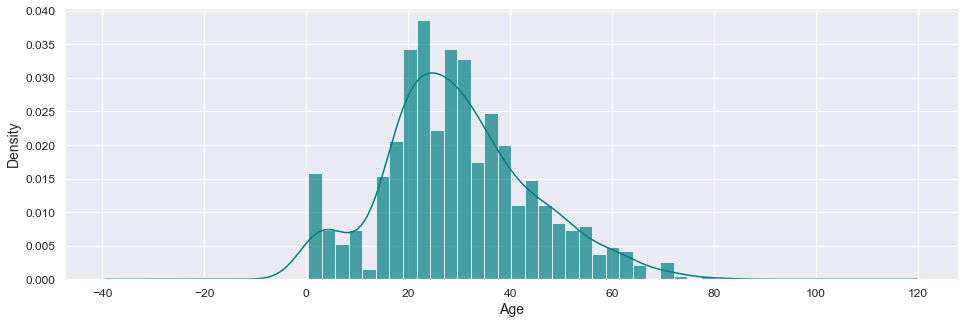

In [1373]:
# Deal with missing ages - mean age is ~ 30 years old
# Age histogram and density plot
ax = train_df['Age'].hist(bins=30, density = True, stacked = True, color = 'teal', alpha = 0.7, figsize = (16,5))
train_df['Age'].plot(kind = 'density', color = 'teal')
ax.set_xlabel('Age')
plt.show()

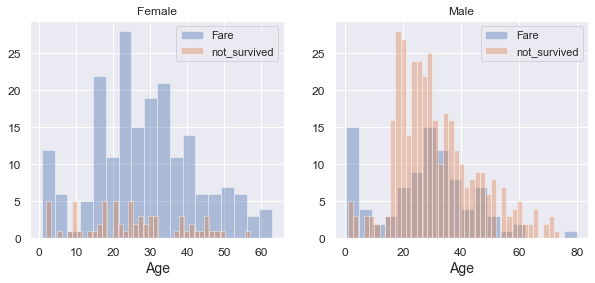

In [1374]:
# Compare ages to sex and survival status
Survived = "Survived"
not_survived = "not_survived"

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
women = train_df[train_df['Sex'] == 'female']
men = train_df[train_df['Sex'] == 'male']

ax = sns.distplot(women[women[Survived]==1].Age.dropna(), bins = 18, label = survived, ax = axes[0], kde = False)
ax = sns.distplot(women[women[Survived]==0].Age.dropna(), bins = 40, label = not_survived, ax = axes[0], kde = False)
ax.legend()
ax.set_title('Female')

ax = sns.distplot(men[men[Survived]==1].Age.dropna(), bins = 18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men[Survived]==0].Age.dropna(), bins = 40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
ax.set_title('Male');

In [1375]:
# Younger men more likely to die
# Men much more likely to die than women
train_df.Survived.value_counts(normalize=True) # 38% survived - imbalanced data

0    0.616162
1    0.383838
Name: Survived, dtype: float64

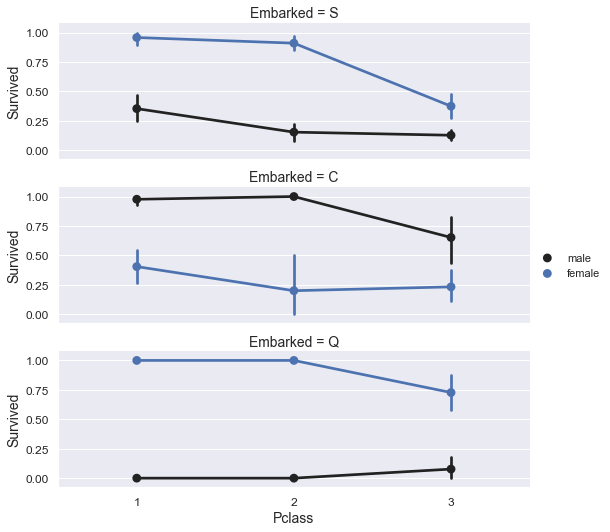

In [1376]:
# Survived by Sex and Pclass split by Embarked
# Men more likely to survive if Embarked = C
# Pclass=1 has highest rate of survival except for Embarked=Q males

f = sns.FacetGrid(train_df, row = 'Embarked', height = 2.5, aspect = 3)
f.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', order = None, hue_order = None)
f.add_legend()

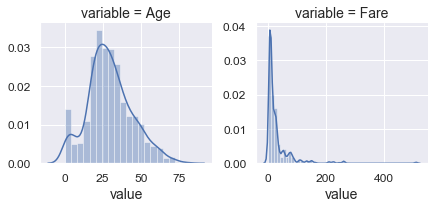

In [1377]:
# Histograms of continuous variables
def hist_plot(data, features):
    d = data
    f = features
    g = pd.melt(d, value_vars = f)
    gm = sns.FacetGrid(g, col = 'variable', col_wrap = 45, sharex = False, sharey = False)
    gm = gm.map(sns.distplot, 'value')
    sns.set(rc={'figure.figsize':(20,20)})
    plt.show;

hist_plot(train_df, ['Age', 'Fare']) # Fare looks very skewed - do I need to transform?

<bound method Figure.show of <Figure size 720x288 with 2 Axes>>

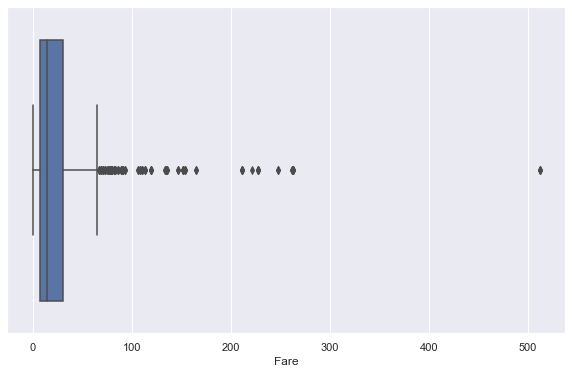

In [1378]:
# Fare boxplot - Data is skewed with many outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fare', data=train_df);
fig.show

In [1379]:
# Remove the largest outlier and rerun distributions
max_fare = train_df['Fare'].idxmax()
print(train_df.iloc[max_fare])
print(max_fare)

PassengerId        259
Survived             1
Pclass               1
Sex             female
Age                 35
SibSp                0
Parch                0
Fare           512.329
Embarked             C
Name: 258, dtype: object
258


In [1380]:
# Fare boxplot - with largest outlier removed
# Get names of indexes for which column Age has value 30
indexNames = train_df[ train_df['Fare'] >500 ].index
 
# Delete these row indexes from dataFrame
train_df.drop(indexNames , inplace=True)
train_df.describe()


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,888.000000,888.000000,888.000000,711.000000,888.000000,888.000000,888.000000
mean,445.618243,0.381757,2.313063,29.675345,0.524775,0.381757,30.582164
std,257.405474,0.486091,0.834007,14.552495,1.104186,0.806949,41.176366
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,2.000000,20.000000,0.000000,0.000000,7.895800
50%,445.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.250000,1.000000,3.000000,38.000000,1.000000,0.000000,30.771850
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,263.000000


<bound method Figure.show of <Figure size 720x288 with 2 Axes>>

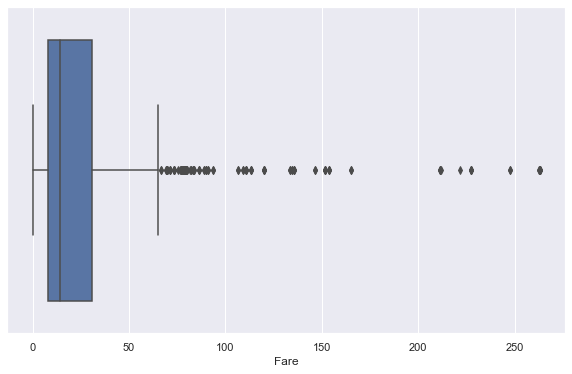

In [1381]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Fare', data=train_df);
fig.show

<bound method Figure.show of <Figure size 720x288 with 2 Axes>>

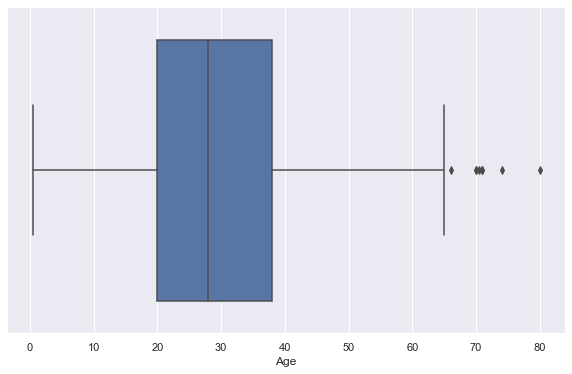

In [1382]:
# Age boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', data=train_df);
fig.show

0    0.761261
1    0.131757
2    0.090090
5    0.005631
3    0.005631
4    0.004505
6    0.001126
Name: Parch, dtype: float64


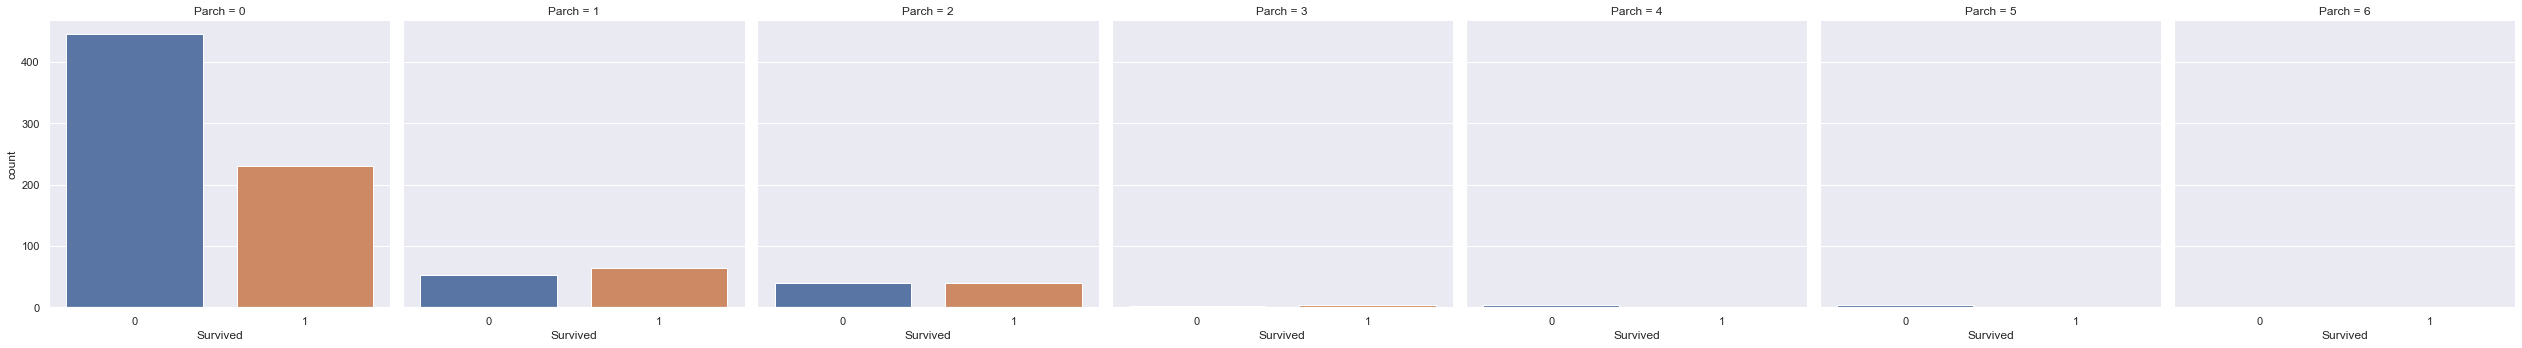

In [1383]:
# Number of Parents/Children Aboard
print(train_df.Parch.value_counts(normalize=True))
sns.catplot(x='Survived', col='Parch', kind='count', data=train_df); # Barplot of Suvived by Parch
# Include - but create dummy variable with 0 or >0

0    0.681306
1    0.235360
2    0.031532
4    0.020270
3    0.018018
8    0.007883
5    0.005631
Name: SibSp, dtype: float64


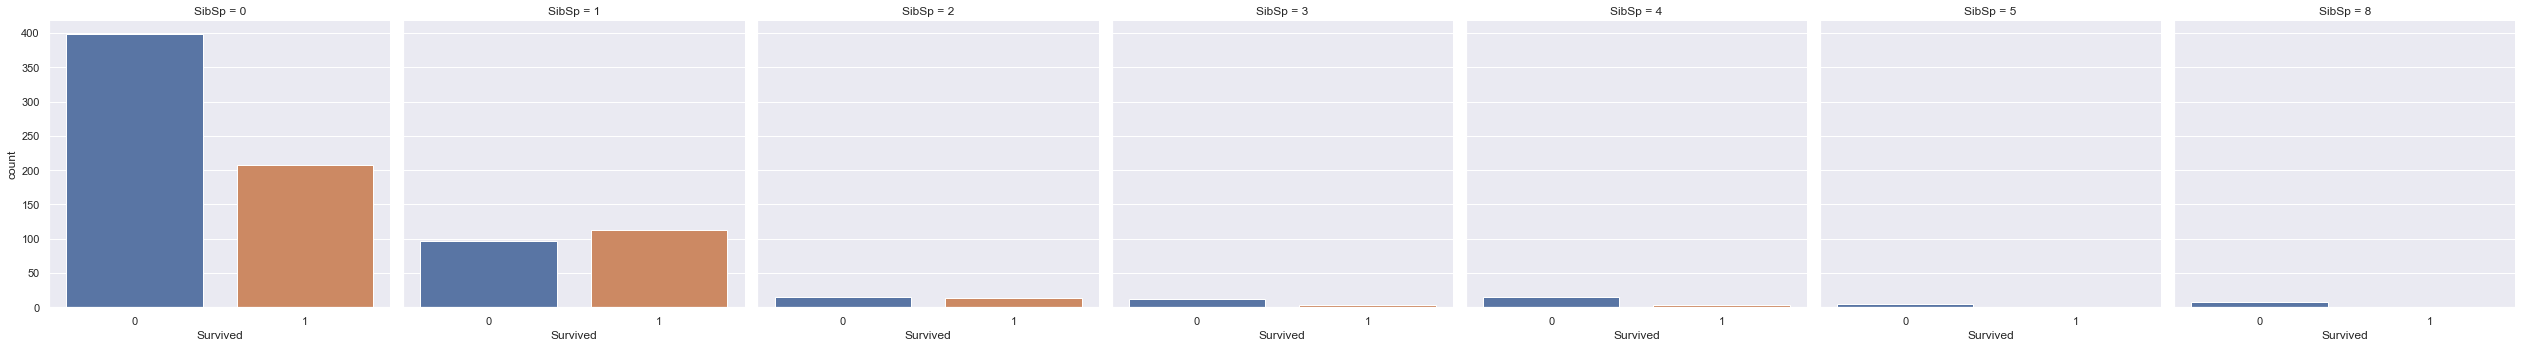

In [1384]:
# Number of Siblings/Spouses Aboard
print(train_df.SibSp.value_counts(normalize=True))
sns.catplot(x='Survived', col='SibSp', kind='count', data=train_df); # Barplot of Suvived by SibSb
# Include - but create dummy variable with 0 or >0

In [1385]:
train_df.Sex.value_counts(normalize=True)

male      0.647523
female    0.352477
Name: Sex, dtype: float64

0    549
1    339
Name: Survived, dtype: int64

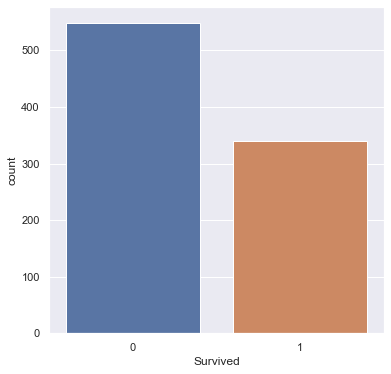

In [1386]:
plt.figure(figsize=(6, 6))
sns.countplot(x='Survived', data=train_df); # Barplot of Suvived
train_df['Survived'].value_counts() # .38 survived; .62 died

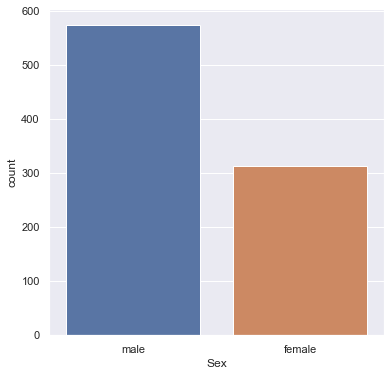

In [1387]:
plt.figure(figsize=(6, 6))
sns.countplot(x='Sex', data=train_df); # Barplot of Sex

3    0.552928
1    0.239865
2    0.207207
Name: Pclass, dtype: float64
Survived         0         1
Pclass                      
1         0.375587  0.624413
2         0.527174  0.472826
3         0.757637  0.242363


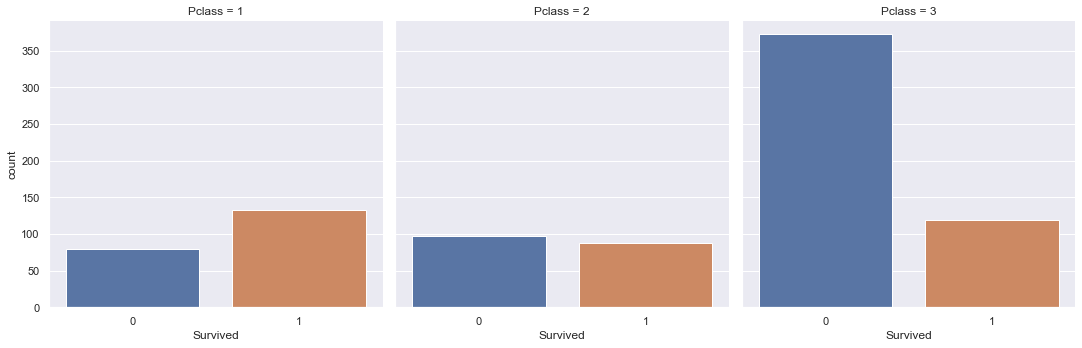

In [1388]:
# Pclass 
print(train_df.Pclass.value_counts(normalize=True))

print(pd.crosstab(train_df.Pclass, train_df.Survived, normalize='index'))
sns.catplot(x='Survived', col='Pclass', kind='count', data=train_df);
# 3rd class was the largest and death rate almost 3x survival rate
# 1st class only class where survival rate > deaths

In [1389]:
pd.crosstab(train_df.Pclass, train_df.Sex, normalize='index')
# Mostly men in 3rd class

Sex,female,male
Pclass,,
1,0.436620,0.563380
2,0.413043,0.586957
3,0.293279,0.706721


0.7412140575079872
0.18608695652173912


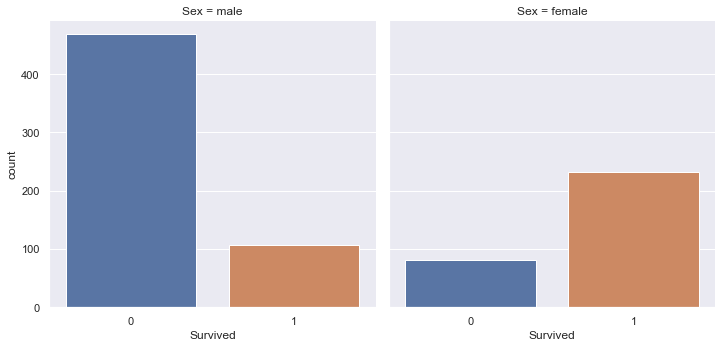

In [1390]:
# Sex
print(train_df[train_df.Sex == 'female'].Survived.sum()/train_df[train_df.Sex == 'female'].Survived.count())
print(train_df[train_df.Sex == 'male'].Survived.sum()/train_df[train_df.Sex == 'male'].Survived.count())
sns.catplot(x='Survived', col='Sex', kind='count', data=train_df); # Barplot of Suvived by Sex

# Only 19% of males survived - seems like the strongest factor

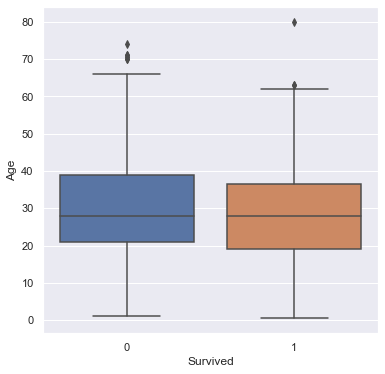

In [1391]:
# Age
plt.figure(figsize=(6, 6))
sns.boxplot(x='Survived', y='Age', data=train_df) # Age does not seem to a huge factor - check age groups

In [1392]:
# Cre

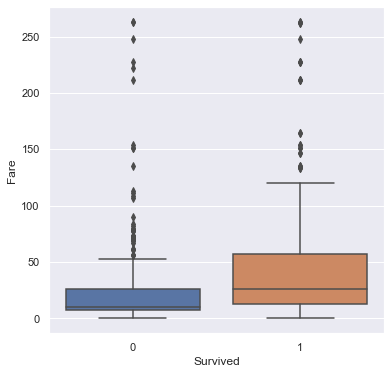

In [1393]:
plt.figure(figsize=(6, 6))
sns.boxplot(x="Survived", y="Fare", data=train_df) 
# Fare distribution is skewed
# Larger the fare, more likley they will survive

In [1394]:
# Correlation of all variables to survived
corr=train_df.corr()
corr['Survived'].sort_values(ascending=False)
# Pclass highest correlated variable, followed by Fare

Survived       1.000000
Fare           0.261742
Parch          0.082157
PassengerId   -0.006916
SibSp         -0.033395
Age           -0.079472
Pclass        -0.334068
Name: Survived, dtype: float64

/Users/rachelmartonik/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


<Figure size 1440x1440 with 0 Axes>

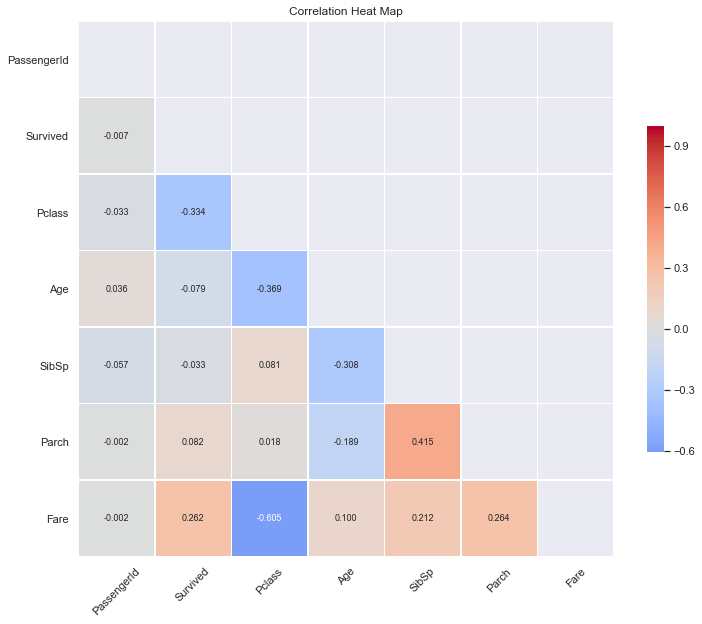

In [1395]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

corr_chart(df_corr = train_df) 


# Prepare the data sets

In [1396]:
#Set up data sets
titanic_train = pd.read_csv('train.csv')
titanic_train = titanic_train.drop(['Name', 'Ticket', 'Cabin'], axis=1) # drop Name and Ticket and Cabin

#Splits
X_train, X_test, y_train, y_test = train_test_split(titanic_train.drop('Survived', axis = 1), 
                                                   titanic_train['Survived'])
y_test=pd.DataFrame(y_test) # save as data frame
y_train=pd.DataFrame(y_train) # save as data frame

In [1397]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(668, 8)
(668, 1)
(223, 8)
(223, 1)


In [1398]:
titanic_train.info() # age and embarked are missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.7+ KB


In [1399]:
# Combine internal test, train, and Kaggle test together to apply same cleans
X_train['train'] = 1
X_test['train'] = 0
titanic_test['train'] = 99
combined = pd.concat([X_train,X_test], axis = 0)
combined.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 77 to 346
Data columns (total 9 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       889 non-null object
train          891 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 69.6+ KB


In [1400]:
# Imputation for Age based on Pclass
print(combined[combined['Pclass']==1]['Age'].mean())
print(combined[combined['Pclass']==2]['Age'].mean())
print(combined[combined['Pclass']==3]['Age'].mean())

38.233440860215055
29.87763005780347
25.14061971830986


In [1401]:
# Impute age by average age by class
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return combined[combined['Pclass']==1]['Age'].mean()
        elif Pclass == 2:
            return combined[combined['Pclass']==2]['Age'].mean()
        elif Pclass == 3:
            return combined[combined['Pclass']==3]['Age'].mean()
        
    else:
        return Age

In [1402]:
# Apply imputation
combined['Age'] = combined[['Age', 'Pclass']].apply(impute_age, axis=1)

In [1403]:
# Impute age by average age by class
def impute_fare(cols):
    Fare = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Fare):
        if Pclass == 1:
            return combined[combined['Pclass']==1]['Fare'].mean()
        elif Pclass == 2:
            return combined[combined['Pclass']==2]['Fare'].mean()
        elif Pclass == 3:
            return combined[combined['Pclass']==3]['Fare'].mean()
        
    else:
        return Fare

In [1404]:
# Apply imputation
combined['Fare'] = combined[['Fare', 'Pclass']].apply(impute_fare, axis=1)

In [1405]:
combined['Embarked'].isnull().sum()

2

In [1406]:
# Embarked - impute by most common value of Embarked
combined['Embarked'].value_counts()
common_value = 'S'
combined['Embarked'].fillna(common_value, inplace = True)

In [1407]:
combined.info() # No more missing data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 77 to 346
Data columns (total 9 columns):
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Fare           891 non-null float64
Embarked       891 non-null object
train          891 non-null int64
dtypes: float64(2), int64(5), object(2)
memory usage: 69.6+ KB


In [1413]:
# Add age groups
# Collapse Age combined AgeGroups
combined.loc[(combined['Age'] <= 16), 'AgeGroup'] = 1
combined.loc[(combined['Age'] > 16) & (combined['Age'] <= 30), 'AgeGroup'] = 2
combined.loc[(combined['Age'] > 30) , 'AgeGroup'] = 3

In [1414]:
# print(full_df.AgeGroup.value_counts(normalize=True))
# print(pd.crosstab(full_df.AgeGroup, train_df.Survived, normalize='index'))

In [1415]:
# Feature transformations - convert to integer
combined['Fare'] = combined['Fare'].astype('int')
combined['Age'] = combined['Age'].astype('int')
combined['Pclass'] = combined['Pclass'].astype('int')
#combined['AgeGroup'] = combined['AgeGroup'].astype('int')

In [1416]:
# Make Pclass into dummy dichotomous variable using OneHotEncoder
Pclass_cat = combined['Pclass'].values # change to array
Pclass_cat = Pclass_cat.reshape(-1, 1) # reshape array
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
Pclass_cat_1hot = cat_encoder.fit_transform(Pclass_cat)
Pclass_cat_1hot
Pclass_cat_1hot = Pclass_cat_1hot.toarray() # change to dense matrix
print(cat_encoder.categories_) # double check categories
# Change back to dataframe to append
Pclass_cat_1hot = pd.DataFrame(Pclass_cat_1hot)
Pclass_cat_1hot.columns=['Pclass_1', 'Pclass_2', 'Pclass_3']

[array([1., 2., 3.])]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [1417]:
# Make AgeGroup into dummy dichotomous variable using OneHotEncoder
AgeGroup_cat = combined['AgeGroup'].values # change to array
AgeGroup_cat = AgeGroup_cat.reshape(-1, 1) # reshape array
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
AgeGroup_cat_1hot = cat_encoder.fit_transform(AgeGroup_cat)
AgeGroup_cat_1hot = AgeGroup_cat_1hot.toarray() # change to dense matrix
print(cat_encoder.categories_) # double check categories
# Change back to dataframe to append
AgeGroup_cat_1hot = pd.DataFrame(AgeGroup_cat_1hot)
AgeGroup_cat_1hot.columns=['AgeGroup_1', 'AgeGroup_2', 'AgeGroup_3' ]

[array([1., 2., 3.])]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [1418]:
#Generate Dummies for categorical variables
cat_dummies = pd.get_dummies(combined.select_dtypes(exclude = ['int','float64','float']))

# Add dummy variables back into data set
full_df = pd.concat([combined.select_dtypes(include = ['int','float64','float']),
                     cat_dummies, Pclass_cat_1hot, AgeGroup_cat_1hot], 
                     axis =1)


In [1419]:
# Collapse Pclass and SibSp
full_df['Parch_0'] = 9
full_df.loc[(full_df['Parch'] == 0), 'Parch_0'] = 0
full_df.loc[(full_df['Parch'] > 0), 'Parch_0'] = 1

full_df['SibSp_0'] = 9
full_df.loc[(full_df['SibSp'] == 0), 'SibSp_0'] = 0
full_df.loc[(full_df['SibSp'] > 0), 'SibSp_0'] = 1

In [1420]:
list(full_df.columns)

['PassengerId',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'train',
 'AgeGroup',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'AgeGroup_1',
 'AgeGroup_2',
 'AgeGroup_3',
 'Parch_0',
 'SibSp_0']

# Final Variable Selection

In [1421]:
############################################################################
##################### Initial model feature selection ######################
############################################################################
# Drop one level of dummy vars
full_df = full_df[['PassengerId','Fare','Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'SibSp_0', 'Parch_0',
                   'Embarked_Q', 'Embarked_C', 'AgeGroup_1', 'AgeGroup_2', 'train']]
full_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Fare           891 non-null int64
Age            891 non-null int64
Sex_female     891 non-null uint8
Pclass_1       891 non-null float64
Pclass_2       891 non-null float64
SibSp_0        891 non-null int64
Parch_0        891 non-null int64
Embarked_Q     891 non-null uint8
Embarked_C     891 non-null uint8
AgeGroup_1     891 non-null float64
AgeGroup_2     891 non-null float64
train          891 non-null int64
dtypes: float64(4), int64(6), uint8(3)
memory usage: 79.2 KB


In [1423]:
# Feature transformations
full_df['Pclass_1'] = full_df['Pclass_1'].astype('int')
full_df['Pclass_2'] = full_df['Pclass_2'].astype('int')
full_df['AgeGroup_1'] = full_df['AgeGroup_1'].astype('int')
full_df['AgeGroup_2'] = full_df['AgeGroup_2'].astype('int')
#full_df['AgeGroup_4'] = full_df['AgeGroup_4'].astype('int')
#full_df['AgeGroup_5'] = full_df['AgeGroup_5'].astype('int')
full_df['Sex_female'] = full_df['Sex_female'].astype('int')
full_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Fare           891 non-null int64
Age            891 non-null int64
Sex_female     891 non-null int64
Pclass_1       891 non-null int64
Pclass_2       891 non-null int64
SibSp_0        891 non-null int64
Parch_0        891 non-null int64
Embarked_Q     891 non-null uint8
Embarked_C     891 non-null uint8
AgeGroup_1     891 non-null int64
AgeGroup_2     891 non-null int64
train          891 non-null int64
dtypes: int64(11), uint8(2)
memory usage: 85.3 KB


In [1241]:
# # Get names of indexes for Fare>500
# indexNames = full_df[ titanic_train['Fare'] >500 ].index
#  # Delete these row indexes from dataFrame
# titanic_train.drop(indexNames , inplace=True)

In [1424]:
#Split out data again into train and test
train = full_df[full_df['train'] == 1]
test = full_df[full_df['train'] == 0]
train = train.drop('train', axis = 1)
test = test.drop('train', axis = 1)

print(train.shape)
print(y_train.shape)
print(test.shape)
print(y_test.shape)

#For submission
# test_id = test['Id']

#Take out for fitting
test = test.drop('PassengerId', axis = 1)
train = train.drop('PassengerId', axis = 1)
train_vars = list(train.columns)


(668, 12)
(668, 1)
(223, 12)
(223, 1)


In [1425]:
train_vars

['Fare',
 'Age',
 'Sex_female',
 'Pclass_1',
 'Pclass_2',
 'SibSp_0',
 'Parch_0',
 'Embarked_Q',
 'Embarked_C',
 'AgeGroup_1',
 'AgeGroup_2']

In [1426]:
# # Remove Fare Outliers
# # Get names of indexes for Fare>500
# indexNames = titanic_train[ titanic_train['Fare'] >500 ].index
#  # Delete these row indexes from dataFrame
# titanic_train.drop(indexNames , inplace=True)

In [1427]:
# Balance the training data since so many cases died
from sklearn.utils import resample
X = pd.concat([train, y_train], axis=1)

# separate minority and majority classes
not_survived = X[X.Survived==0]
survived = X[X.Survived==1]

# upsample minority
alive_upsampled = resample(survived,
                          replace=True, # sample with replacement
                          n_samples=len(not_survived), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_survived, alive_upsampled])

# check new class counts
print(upsampled.Survived.value_counts())

# Shuffle the balanced data
upsampled = upsampled.sample(frac=1).reset_index(drop=True)
upsampled

y_train_bal = upsampled.Survived
X_train_bal = upsampled.drop('Survived', axis=1)

print(y_train_bal.shape)
print(X_train_bal.shape)

1    411
0    411
Name: Survived, dtype: int64
(822,)
(822, 11)


In [1428]:
# Change inputs to arrays
y_train_bal=y_train_bal.values
X_train_bal=X_train_bal.values
y_test = y_test.values
X_test = test.values

# Logistic Regression

In [1429]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
logreg = LogisticRegression()

# Pretty print a confusion matrixes rows actual, columns predicted
# Adapted from: https://gist.github.com/zachguo/10296432
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, 
             hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()
    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.0f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

In [1430]:
logreg.fit(X_train_bal, y_train_bal) # Train the model on the balanced data

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [1431]:
print("Training set score: {:.3f}".format(logreg.score(X_train_bal, y_train_bal)))
print("Testing set score: {:.3f}".format(logreg.score(X_test, y_test)))
print("lr.coef_:", logreg.coef_)
print("lr.intercept_:", logreg.intercept_)

Training set score: 0.765
Testing set score: 0.565
lr.coef_: [[ 0.012 -0.017  2.318 -0.152 -0.056 -0.039 -0.132 -0.01   0.809  0.054
   0.052]]
lr.intercept_: [-0.784]


In [1432]:
y_pred = (logreg.predict(X_test))
y_pred

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0])

In [1433]:
# Precision and Recall Scores for test data set
from sklearn.metrics import precision_score, recall_score
print('\n Precision:',  
precision_score(y_test, y_pred))
print('\n Recall:',recall_score(y_test, y_pred)) 

# Confusion matrix
overage_labels = ['Died', 'Survived'] 

print('\n Confusion Matrix (rows actual, columns predicted)\n')
print_cm(confusion_matrix(y_test, y_pred),
                 labels = overage_labels)



 Precision: 0.43333333333333335

 Recall: 0.4588235294117647

 Confusion Matrix (rows actual, columns predicted)

                 Died Survived 
        Died       87       51 
    Survived       46       39 


In [1152]:
# Precision Recall Graph - TRAIN DATA
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(logreg, X_train_bal, y_train_bal, cv=3,
                             method="decision_function")

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [1153]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_bal, y_scores)

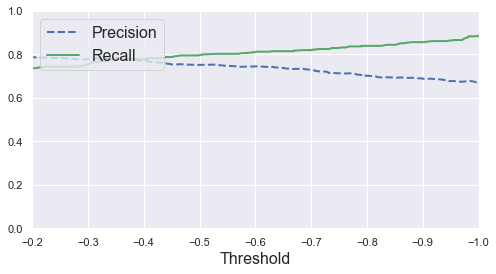

In [1154]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-.2, -1])
plt.show()

In [1155]:
# TRAIN DATA RESULTS
y_pred = (logreg.predict(X_train_bal))
from sklearn.metrics import classification_report
print(classification_report(y_train_bal, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       410
           1       0.81      0.72      0.76       410

    accuracy                           0.78       820
   macro avg       0.78      0.78      0.78       820
weighted avg       0.78      0.78      0.78       820



In [1156]:
# TEST DATA RESULTS
y_pred = (logreg.predict(X_test))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.56      0.58       139
           1       0.35      0.39      0.37        84

    accuracy                           0.50       223
   macro avg       0.48      0.48      0.48       223
weighted avg       0.51      0.50      0.50       223



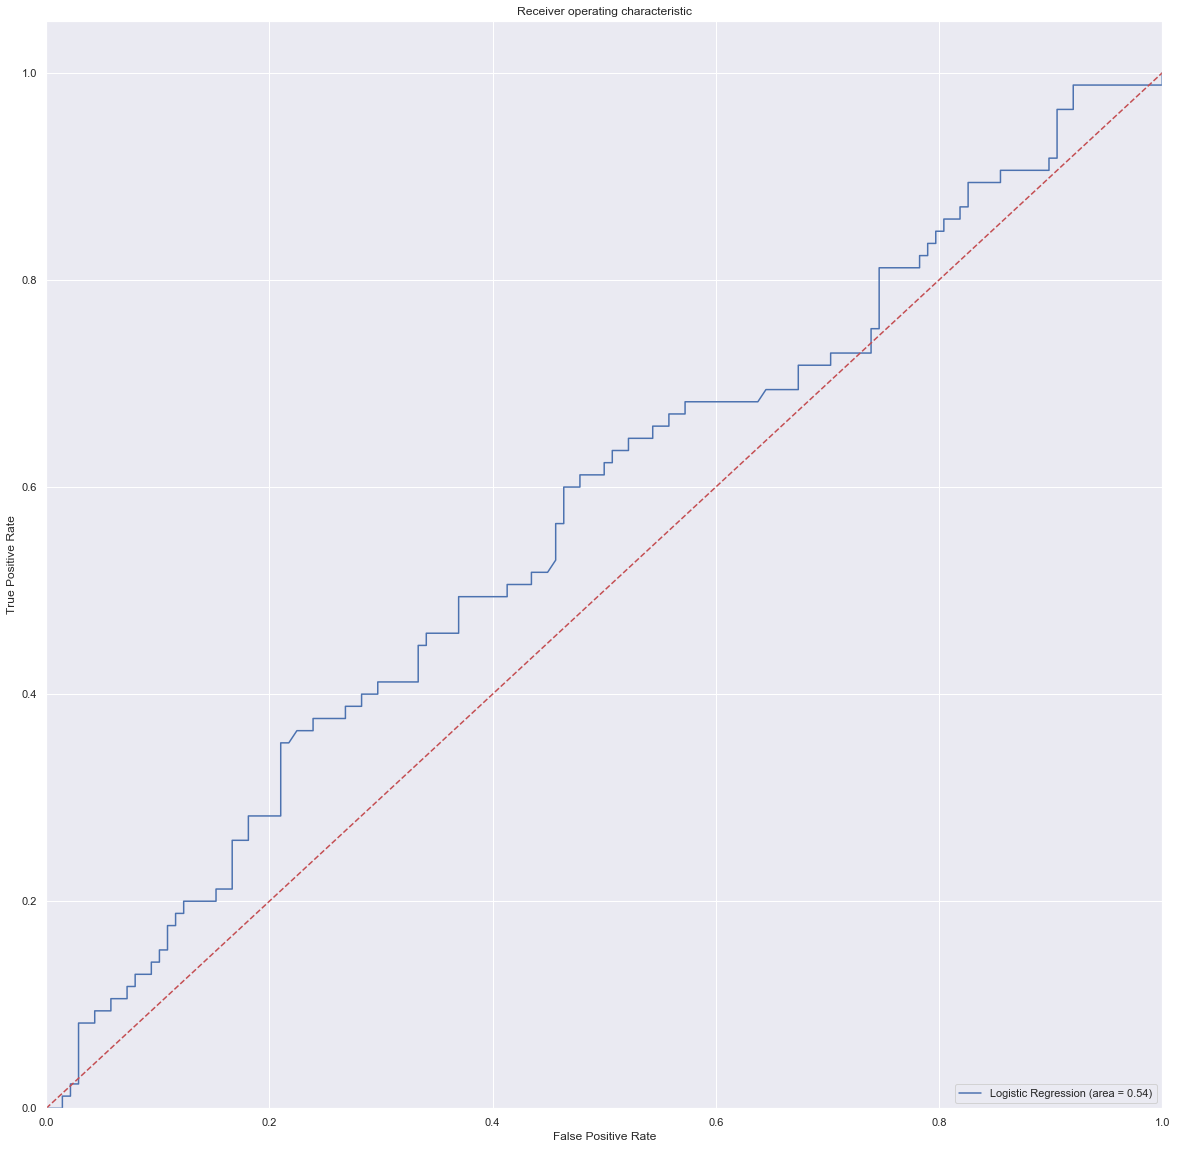

In [1435]:
# ROC curve - TEST SET - This is terrible - barely better than a flip of a coin
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

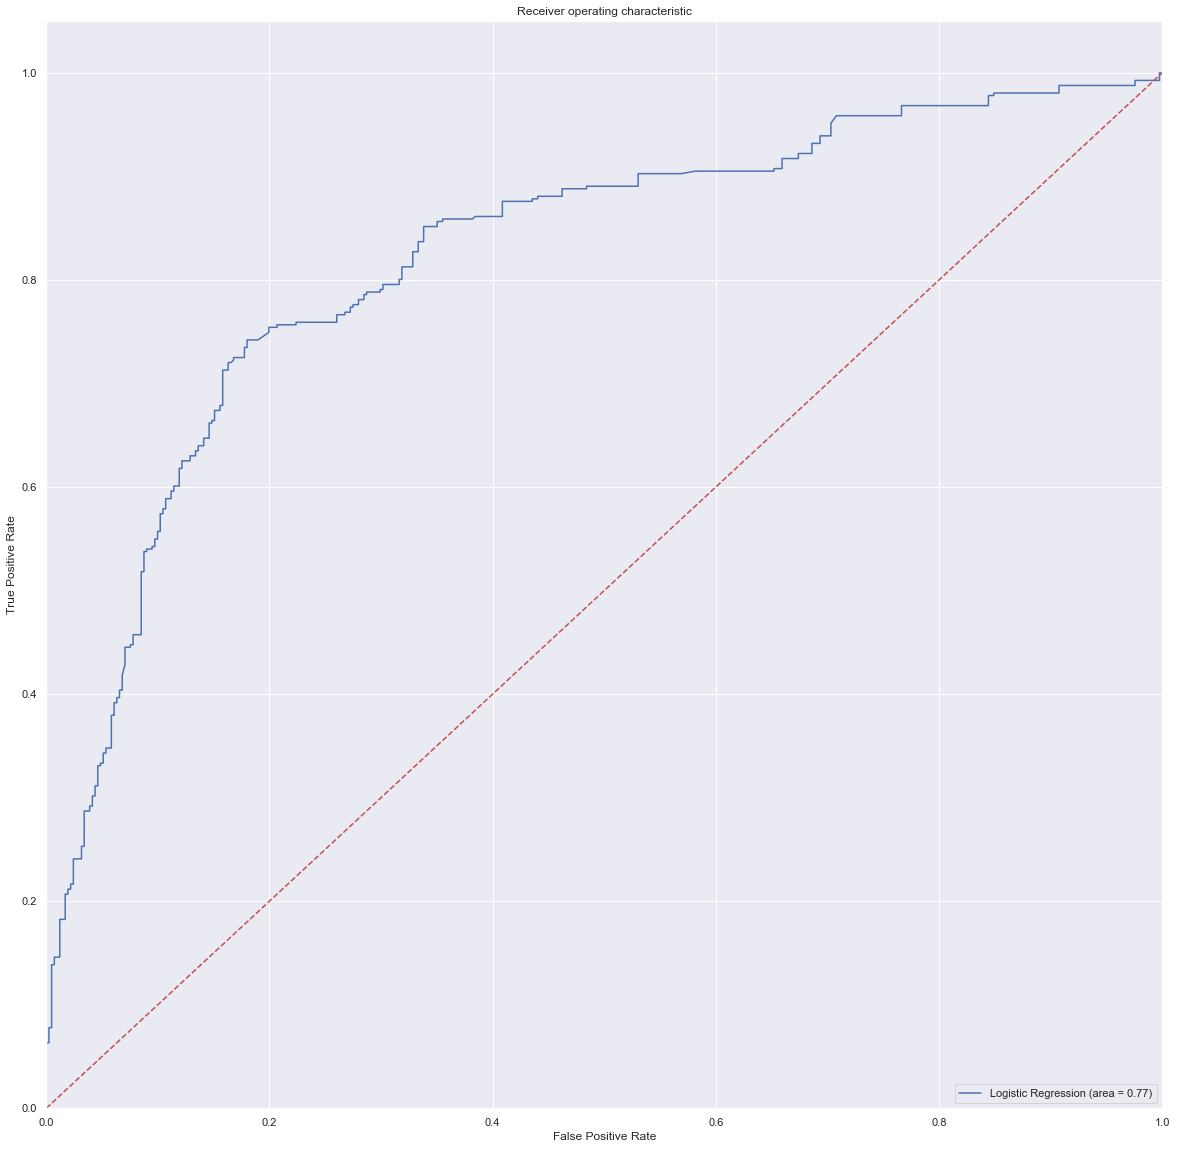

In [1434]:
# ROC curve - TRAIN SET
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_train_bal, logreg.predict(X_train_bal))
fpr, tpr, thresholds = roc_curve(y_train_bal, logreg.predict_proba(X_train_bal)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [1159]:
# Grid Search to find best model
logreg = LogisticRegression()
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = clf.fit(X_train_bal, y_train_bal)

# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

Best Penalty: l1
Best C: 1.0


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

In [1160]:
best_model_pred =best_model.predict(X_train_bal) # Fit with best model from cross validation
print(precision_score(y_train_bal, best_model_pred)) 
print(recall_score(y_train_bal, best_model_pred)) 
confusion_matrix(y_train_bal, best_model_pred)

0.8131868131868132
0.7219512195121951


array([[342,  68],
       [114, 296]])

In [1161]:
best_model_pred =best_model.predict(X_test) # Fit with best model from cross validation
print(precision_score(y_test, best_model_pred)) 
print(recall_score(y_test, best_model_pred)) 
confusion_matrix(y_test, best_model_pred)

0.35106382978723405
0.39285714285714285


array([[78, 61],
       [51, 33]])

# Kaggle Submission

In [1472]:
# Prepare Data Set - apply same cleans/transformations as done on training set
titanic_test = pd.read_csv('test.csv')
Kaggle_test_ID = titanic_test['PassengerId']
titanic_test = titanic_test.drop(['Name', 'Ticket', 'Cabin','PassengerId'], axis=1) # drop Name and Ticket and Cabin

In [1473]:
# Check for mising data - Age and Fare
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        417 non-null float64
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 22.9+ KB


In [1474]:
# Imputation for Age based on Pclass
print(titanic_test[titanic_test['Pclass']==1]['Age'].mean())
print(titanic_test[titanic_test['Pclass']==2]['Age'].mean())
print(titanic_test[titanic_test['Pclass']==3]['Age'].mean())

40.91836734693877
28.7775
24.02794520547945


In [1475]:
# Impute age by average age by class
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return titanic_test[titanic_test['Pclass']==1]['Age'].mean()
        elif Pclass == 2:
            return titanic_test[titanic_test['Pclass']==2]['Age'].mean()
        elif Pclass == 3:
            return titanic_test[titanic_test['Pclass']==3]['Age'].mean()
        
    else:
        return Age
    
# Apply imputation
titanic_test['Age'] = titanic_test[['Age', 'Pclass']].apply(impute_age, axis=1)

In [1476]:
# Impute Fare by average age by class
def impute_fare(cols):
    Fare = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Fare):
        if Pclass == 1:
            return titanic_test[titanic_test['Pclass']==1]['Fare'].mean()
        elif Pclass == 2:
            return titanic_test[titanic_test['Pclass']==2]['Fare'].mean()
        elif Pclass == 3:
            return titanic_test[titanic_test['Pclass']==3]['Fare'].mean()
        
    else:
        return Fare
    
# Apply imputation
titanic_test['Fare'] = titanic_test[['Fare', 'Pclass']].apply(impute_fare, axis=1)

In [1477]:
# Add age groups
# Collapse Age combined AgeGroups
titanic_test.loc[(titanic_test['Age'] <= 16), 'AgeGroup'] = 1
titanic_test.loc[(titanic_test['Age'] > 16) & (titanic_test['Age'] <= 30), 'AgeGroup'] = 2
titanic_test.loc[(titanic_test['Age'] > 30), 'AgeGroup'] = 3

titanic_test.AgeGroup.value_counts()

2.0    243
3.0    141
1.0     34
Name: AgeGroup, dtype: int64

In [1478]:
# Feature transformations - convert to integer
titanic_test['Fare'] = titanic_test['Fare'].astype('int')
titanic_test['Age'] = titanic_test['Age'].astype('int')
titanic_test['Pclass'] = titanic_test['Pclass'].astype('int')
#combined['AgeGroup'] = combined['AgeGroup'].astype('int')

In [1479]:
# Make Pclass into dummy dichotomous variable using OneHotEncoder
Pclass_cat = titanic_test['Pclass'].values # change to array
Pclass_cat = Pclass_cat.reshape(-1, 1) # reshape array
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
Pclass_cat_1hot = cat_encoder.fit_transform(Pclass_cat)
Pclass_cat_1hot
Pclass_cat_1hot = Pclass_cat_1hot.toarray() # change to dense matrix
print(cat_encoder.categories_) # double check categories
# Change back to dataframe to append
Pclass_cat_1hot = pd.DataFrame(Pclass_cat_1hot)
Pclass_cat_1hot.columns=['Pclass_1', 'Pclass_2', 'Pclass_3']

[array([1., 2., 3.])]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [1480]:
# Make AgeGroup into dummy dichotomous variable using OneHotEncoder
AgeGroup_cat = titanic_test['AgeGroup'].values # change to array
AgeGroup_cat = AgeGroup_cat.reshape(-1, 1) # reshape array
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
AgeGroup_cat_1hot = cat_encoder.fit_transform(AgeGroup_cat)
AgeGroup_cat_1hot = AgeGroup_cat_1hot.toarray() # change to dense matrix
print(cat_encoder.categories_) # double check categories
# Change back to dataframe to append
AgeGroup_cat_1hot = pd.DataFrame(AgeGroup_cat_1hot)
AgeGroup_cat_1hot.columns=['AgeGroup_1', 'AgeGroup_2', 'AgeGroup_3' ]

[array([1., 2., 3.])]


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [1481]:
#Generate Dummies for categorical variables
cat_dummies = pd.get_dummies(titanic_test.select_dtypes(exclude = ['int','float64','float']))

# Add dummy variables back into data set
full_df = pd.concat([titanic_test.select_dtypes(include = ['int','float64','float']),
                     cat_dummies, Pclass_cat_1hot, AgeGroup_cat_1hot], 
                     axis =1)

In [1482]:
# Collapse Pclass and SibSp
full_df['Parch_0'] = 9
full_df.loc[(full_df['Parch'] == 0), 'Parch_0'] = 0
full_df.loc[(full_df['Parch'] > 0), 'Parch_0'] = 1

full_df['SibSp_0'] = 9
full_df.loc[(full_df['SibSp'] == 0), 'SibSp_0'] = 0
full_df.loc[(full_df['SibSp'] > 0), 'SibSp_0'] = 1

In [1483]:
############################################################################
##################### Initial model feature selection ######################
############################################################################
# Drop one level of dummy vars
full_df = full_df[['Fare','Age', 'Sex_female', 'Pclass_1', 'Pclass_2', 'SibSp_0', 'Parch_0',
                   'Embarked_Q', 'Embarked_C', 'AgeGroup_1', 'AgeGroup_2', ]]
full_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
Fare          418 non-null int64
Age           418 non-null int64
Sex_female    418 non-null uint8
Pclass_1      418 non-null float64
Pclass_2      418 non-null float64
SibSp_0       418 non-null int64
Parch_0       418 non-null int64
Embarked_Q    418 non-null uint8
Embarked_C    418 non-null uint8
AgeGroup_1    418 non-null float64
AgeGroup_2    418 non-null float64
dtypes: float64(4), int64(4), uint8(3)
memory usage: 27.4 KB


In [1484]:
# Feature transformations
full_df['Pclass_1'] = full_df['Pclass_1'].astype('int')
full_df['Pclass_2'] = full_df['Pclass_2'].astype('int')
full_df['AgeGroup_1'] = full_df['AgeGroup_1'].astype('int')
full_df['AgeGroup_2'] = full_df['AgeGroup_2'].astype('int')
#full_df['AgeGroup_4'] = full_df['AgeGroup_4'].astype('int')
#full_df['AgeGroup_5'] = full_df['AgeGroup_5'].astype('int')
full_df['Sex_female'] = full_df['Sex_female'].astype('int')
full_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
Fare          418 non-null int64
Age           418 non-null int64
Sex_female    418 non-null int64
Pclass_1      418 non-null int64
Pclass_2      418 non-null int64
SibSp_0       418 non-null int64
Parch_0       418 non-null int64
Embarked_Q    418 non-null uint8
Embarked_C    418 non-null uint8
AgeGroup_1    418 non-null int64
AgeGroup_2    418 non-null int64
dtypes: int64(9), uint8(2)
memory usage: 30.3 KB


In [1485]:
Kaggle_predictions = logreg.predict(Kaggle_test) # fit the model to Kaggle data
Kaggle_predictions = pd.DataFrame(Kaggle_predictions)

In [1487]:
Kaggle_predictions.columns = ['Survived']
Kaggle_predictions



Kaggle_test_ID=pd.DataFrame(Kaggle_test_ID)
Kaggle_submission = pd.concat([Kaggle_test_ID,Kaggle_predictions], axis = 1)
Kaggle_submission.to_csv(r'/Users/rachelmartonik/MSDS_422/Kaggle/Titanic_Log.csv', index=False)


In [1488]:
Kaggle_submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


# Additional Cross Validation and GridSearch

In [1225]:
# Import the required libraries
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression

In [1226]:
# Perform k-fold cross-validation as initial start; guess C and penalty hyperparameters
kfold = KFold(n_splits = 5, random_state = 42)

In [1227]:
model = LogisticRegression(C = 5, penalty = 'l2')
results = cross_val_score(model, X_train_bal, y_train_bal, cv = kfold)
print(results)

# Display all results
print('Accuracy:', results.mean() * 100.0)   # Display accuracy as the mean of the results


[0.745 0.752 0.774 0.738 0.768]
Accuracy: 75.54915003695491


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

In [1228]:
# Perform hyperparameter tuning
logistic = LogisticRegression()    # Instantiate the logistic regression
penalty = ['l1']   # List of penalty values to test
C = np.logspace(0, 4, 10, 100, 10000)    # List options to test for C

In [1229]:
# Create a data dictionary of the options
Hyperparameters = dict(C = C, penalty = penalty)

In [1230]:
# Fit the model using GridSearch
clf = GridSearchCV(logistic, Hyperparameters, cv = 5, verbose = 0)
best_model = clf.fit(X_train_bal, y_train_bal)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

In [1231]:
# Display the best penalty and C value
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l1
Best C: 59.94842503189409


In [1232]:
# Perform k-fold cross-validation with best parameters
kfold = KFold(n_splits = 5, random_state = 42)
model = LogisticRegression(C = 59.9, penalty = 'l1')     # Replace C and penalty with best values
results = cross_val_score(model, X_train_bal, y_train_bal, cv = kfold)
print(results) 
# Display all results
print('Accuracy:', results.mean() * 100.0)   # Display accuracy as the mean of the results

[0.745 0.752 0.774 0.744 0.768]
Accuracy: 75.67110125646713


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

In [1235]:
# Predict best model on test data
model.fit(X_test, y_test)
y_pred = (model.predict(test))
# Precision and Recall Scores for test data set
from sklearn.metrics import precision_score, recall_score
print('\n Precision:',  
precision_score(y_test, y_pred))
print('\n Recall:',recall_score(y_test, y_pred)) 

# Confusion matrix
overage_labels = ['Died', 'Survived'] 

print('\n Confusion Matrix (rows actual, columns predicted)\n')
print_cm(confusion_matrix(y_test, y_pred),
                 labels = overage_labels)


 Precision: 0.4166666666666667

 Recall: 0.11764705882352941

 Confusion Matrix (rows actual, columns predicted)

                 Died Survived 
        Died      124       14 
    Survived       75       10 


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Gradient Boosted Trees

In [1237]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train_bal, y_train_bal)
y_pred = (gbrt.predict(X_test))
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train_bal, y_train_bal)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

# Precision and Recall Scores for test data set
from sklearn.metrics import precision_score, recall_score
print('\n Precision:',  
precision_score(y_test, y_pred))
print('\n Recall:',recall_score(y_test, y_pred)) 

# Confusion matrix
overage_labels = ['Died', 'Survived'] 

print('\n Confusion Matrix (rows actual, columns predicted)\n')
print_cm(confusion_matrix(y_test, y_pred),
                 labels = overage_labels)

Accuracy on training set: 0.887
Accuracy on test set: 0.538

 Precision: 0.39285714285714285

 Recall: 0.38823529411764707

 Confusion Matrix (rows actual, columns predicted)

                 Died Survived 
        Died       87       51 
    Survived       52       33 


In [1238]:
# Tuning parameters
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1, learning_rate=.01, n_estimators=100)
gbrt.fit(X_train_bal, y_train_bal)
y_pred = (gbrt.predict(X_test))
print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train_bal, y_train_bal)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(test, y_test)))

# Precision and Recall Scores for test data set
from sklearn.metrics import precision_score, recall_score
print('\n Precision:',  
precision_score(y_test, y_pred))
print('\n Recall:',recall_score(y_test, y_pred)) 

# Confusion matrix
overage_labels = ['Died', 'Survived'] 

print('\n Confusion Matrix (rows actual, columns predicted)\n')
print_cm(confusion_matrix(y_test, y_pred),
                 labels = overage_labels)

Accuracy on training set: 0.764
Accuracy on test set: 0.543

 Precision: 0.3835616438356164

 Recall: 0.32941176470588235

 Confusion Matrix (rows actual, columns predicted)

                 Died Survived 
        Died       93       45 
    Survived       57       28 


# Random Forest